# Исследование опережающих корреляций для BTC

Искомый датасет подготовлен в рамках курса "Временные ряды для прогноза криптовалют", дополнительная дата получена с Kaggle. Необходимо построить предсказание курса BTC для недели 8-14 июля 2023 на основе данных из ПРОШЛОГО. Мое решение удовлетворяет данному естественному требованию, в чем вы можете убедиться во время ознакомления с ноутбуком. Частично ориентировался на данную статью: https://cointelegraph.com/news/bitcoin-assets-most-correlated-assets-today и на этот ноутбук: https://github.com/tinkoff-ai/etna/blob/master/examples/NN_examples.ipynb

Буду проверять наличие зависимостей с Золотом, Серебром, ETH и информацией с отдельно взятой биржи - Binance

## Подготовка даты

Для начала подключим нужные модули и загрузим main дату:

In [1]:
#! pip install etna #--quiet
#! pip install etna[torch] #--quiet

In [2]:
import numpy as np
import pandas as pd

from datetime import datetime
import random

import torch
from torch.utils.data import DataLoader as DataLoader

In [3]:
from etna.analysis import plot_backtest
from etna.datasets import TSDataset
from etna.metrics import MAE, SMAPE
from etna.models.nn.deepar import DeepARModel
from etna.models.nn.tft import TFTModel
from etna.pipeline import Pipeline

from etna.transforms import DateFlagsTransform, HolidayTransform, LagTransform, StandardScalerTransform

/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/settings.py:53: UserWarning: etna[prophet] is not available, to install it, run `pip install etna[prophet]`
  warnings.warn("etna[prophet] is not available, to install it, run `pip install etna[prophet]`")
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/settings.py:62: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  warnings.warn("etna[classification] is not available, to install it, run `pip install etna[classification]`")
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/settings.py:79: UserWarning: etna[statsforecast] is not available, to install it, run `pip install etna[statsforecast]`
  warnings.warn("etna[

In [4]:
!wget  -O 'Bitcoin_kaggle.csv' -q 'https://www.dropbox.com/scl/fi/gv5l69x4btxy0525x8vz6/Bitcoin_kaggle.csv?rlkey=r9it4a8ruwiv4vjnwx08cpgr1&dl=0'

In [5]:
path = "Bitcoin_kaggle.csv"
df_main = pd.read_csv(path, delimiter=';', parse_dates=True, index_col='Date')
df_main.head(10)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-07-14,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-13,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-12,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-11,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-10,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-09,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-08,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-07,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-06,"29,913.1","30,512.8","31,463.6","29,869.0",90.81K,-1.97%


Последние семь записей дублируют восьмую, так как цену на них и нужно предсказать. Пока удалим их:

In [6]:
df_main = df_main[7:]

Еще немного преобразований для main даты:

In [7]:
for col in ['Price', 'Open', 'High', 'Low']:
    df_main[col] = df_main[col].apply(lambda x: float(x.replace(",","")))
df_main['Vol.'] = df_main['Vol.'].replace({"K":"*1e3", "M":"*1e6", 'B':'*1e9'}, regex=True).map(pd.eval)
# df_main['Change %'] = df_main['Change %'].apply(lambda x: float(x.replace("%","")))
df_main = df_main.drop(columns=['Change %'])

Добавим возможность использовать дополнительную дату:

In [8]:
!wget  -O 'gold.csv' -q 'https://www.dropbox.com/scl/fi/p3yjrmll7g18nmqgzq1pm/gold-prices.csv?rlkey=b839f09hctmo23i5ib9e0dtgc&dl=0'
!wget  -O 'silver.csv' -q 'https://www.dropbox.com/scl/fi/d2zpyn9emm41sespi2l16/silver-prices.csv?rlkey=pudjpwq1hbykgr0efh0yvyayv&dl=0'
!wget  -O 'eth.csv' -q 'https://www.dropbox.com/scl/fi/9aj9srozkhs87c8710bjz/ETH-USD.csv?rlkey=byw2txha1gpie78vj9rep2rgu&dl=0'
!wget  -O 'binance.csv' -q 'https://www.dropbox.com/scl/fi/x9p9senmyn28s66uh56tq/BTCUSDT_binance.csv?rlkey=o8whyy43j02dsryt7dd581p2x&dl=0'

Определим первую и последнюю дату в main датасете:

In [9]:
first_index = df_main.head(1).index[0]
last_index = df_main.tail(1).index[0]
print(first_index)
print(last_index)

2023-07-07 00:00:00
2022-01-14 00:00:00


In [10]:
def add_eth():
  global df_main
  path = "eth.csv"
  df_tmp = pd.read_csv(path, delimiter=',', parse_dates=True, index_col='Date')
  df_tmp = df_tmp.loc[::-1,:]
  df_tmp = df_tmp.loc[first_index:last_index]
  df_tmp = df_tmp.drop(columns=["Adj Close"])
  df_tmp.rename(columns={'Close': 'Close ETH',
                         'Volume':'Volume ETH',
                         'Open':  'Open ETH',
                         'High':  'High ETH',
                         'Low':   'Low ETH'}, inplace=True)
  df_main = pd.concat([df_main, df_tmp], axis=1)


def add_binance():
    global df_main
    path = "binance.csv"
    df_tmp = pd.read_csv(path, delimiter=',')
    df_tmp['Date'] = df_tmp['Open_Time'].apply(lambda x: datetime.utcfromtimestamp(x / 1000))
    df_tmp = df_tmp.set_index("Date")
    df_tmp = df_tmp[["QAV", "NoT", "Taker buy base asset volume", "Taker buy quote asset volume"]]
    df_tmp = df_tmp.loc[::-1,:]
    df_tmp = df_tmp.loc[first_index:last_index]
    df_main = pd.concat([df_main, df_tmp], axis=1)

def add_metal(metal : str):
  global df_main
  path = f"{metal}.csv"
  df_tmp = pd.read_csv(path, delimiter=',', parse_dates=True, index_col='Date')
  df_tmp = df_tmp.loc[first_index:last_index]
  df_tmp.rename(columns={'Close/Last':f'Close {metal}',
                         'Volume':    f'Volume {metal}',
                         'Open':      f'Open {metal}',
                         'High':      f'High {metal}',
                         'Low':       f'Low {metal}'}, inplace=True)
  df_main = pd.concat([df_main, df_tmp], axis=1)

In [11]:
add_eth()
add_binance()
#add_metal('gold')
#add_metal('silver')
df_main.head(10)

,Price,Open,High,Low,Vol.,Open ETH,High ETH,Low ETH,Close ETH,Volume ETH,QAV,NoT,Taker buy base asset volume,Taker buy quote asset volume
Date,,,,,,,,,,,,,,
2023-07-07,30346.4,29912.7,30442.0,29757.4,46420.0,1847.512573,1876.963257,1832.025391,1870.602539,6468885150,1.027462e+09,912948,14875.86309,4.486388e+08
2023-07-06,29913.1,30512.8,31463.6,29869.0,90810.0,1910.417114,1956.012329,1847.850708,1848.636475,8905008384,2.181764e+09,1397042,33952.63237,1.039137e+09
2023-07-05,30512.8,30768.6,30875.6,30233.3,43230.0,1936.796753,1942.432495,1897.124756,1910.588013,6034088075,1.013695e+09,827926,15619.11716,4.764783e+08
2023-07-04,30768.4,31152.0,31326.5,30657.8,42120.0,1955.524170,1966.365356,1932.611328,1936.633545,5683423776,1.028794e+09,779472,14107.36566,4.371262e+08
2023-07-03,31151.3,30617.5,31377.0,30581.5,56490.0,1937.883789,1974.775024,1934.688843,1955.389160,7858509087,1.352635e+09,781855,20885.94331,6.456987e+08
2023-07-02,30617.7,30587.1,30769.0,30227.9,28820.0,1924.448120,1958.160767,1895.906982,1937.438354,6343966490,7.110314e+08,591533,10630.24740,3.246160e+08
2023-07-01,30586.8,30472.9,30649.9,30329.0,22460.0,1933.323853,1942.701538,1910.848633,1924.565918,5136809625,5.338593e+08,567975,8102.13876,2.471751e+08
2023-06-30,30472.9,30445.7,31275.5,29714.5,118650.0,1852.008423,1945.274292,1831.281006,1933.188965,12895131248,2.726356e+09,1559366,44319.81254,1.351735e+09
2023-06-29,30445.7,30077.3,30823.1,30051.3,49570.0,1828.059326,1876.530273,1828.059326,1852.227295,5677228612,1.107940e+09,758428,17834.38857,5.438727e+08


Во время локальных тестов металлы не помогли, в отличие от ETH и информации с Binance. Более того, данные за выходные о торговле металлами полностью состоят из NaN-ов. Методы загрузки соответствующей даты оставлю для энтузиастов.

In [12]:
df_main = df_main.dropna()

In [13]:
df_main.rename(columns={'Price': 'target', 'Date': 'timestamp', 'Vol.': 'Vol'}, inplace=True)
df_main['segment']='main'
df_main['timestamp'] = df_main.index
df_target = TSDataset.to_dataset(df=df_main[["target", "segment", "timestamp"]])
df_target = df_target.dropna()
df_target.head(10)

segment,main
feature,target
timestamp,
2022-01-14,43073.3
2022-01-15,43097.0
2022-01-16,43079.1
2022-01-17,42209.3
2022-01-18,42364.6
2022-01-19,41677.8
2022-01-20,40715.9
2022-01-21,36475.5


In [14]:
df_exog = TSDataset.to_dataset(df=df_main.drop(columns=["target"]))
df_exog.head(10)

segment            main                                                       \
feature       Close ETH     High     High ETH      Low      Low ETH      NoT   
timestamp                                                                      
2022-01-14  3310.001465  43435.1  3330.766113  41848.7  3203.823730   946938   
2022-01-15  3330.530762  43777.9  3364.537842  42586.1  3278.670898   752688   
2022-01-16  3350.921875  43462.0  3376.401123  42643.3  3291.563721   732171   
2022-01-17  3212.304932  43179.6  3355.819336  41559.4  3157.224121   918029   
2022-01-18  3164.025146  42674.2  3236.016113  41300.7  3096.123535   905061   
2022-01-19  3095.825928  42558.0  3171.158447  41160.9  3055.212402   924528   
2022-01-20  3001.120117  43487.1  3265.336914  40568.3  3000.908203  1098761   
2022-01-21  2557.931641  41104.6  3029.081055  35503.9  2496.812988  2092561   
2022-01-22  2405.181152  36749.8  2615.247314  34116.0  2330.247314  2099978   
2022-01-23  2535.039063  36513.0  2542.144775  34655.2  2381.515137  1142407   

segment                                                                     \
feature        Open     Open ETH           QAV Taker buy base asset volume   
timestamp                                                                    
2022-01-14  42562.2  3248.648682  1.392000e+09                15434.189450   
2022-01-15  43073.6  3309.844238  9.464883e+08                11133.186150   
2022-01-16  43079.2  3330.387207  8.872031e+08                10052.192910   
2022-01-17  43080.5  3350.947266  1.169382e+09                13448.541920   
2022-01-18  42209.9  3212.287598  1.228460e+09                14527.823710   
2022-01-19  42365.3  3163.850342  1.327478e+09                15603.743040   
2022-01-20  41683.6  3095.271729  1.784801e+09                20201.479910   
2022-01-21  40698.1  3002.956787  3.405502e+09                41615.085819   
2022-01-22  36467.7  2561.145264  3.207531e+09                42722.278233   
2022-01-23  35072.9  2406.924316  1.572415e+09                22841.394510   

segment                                                         
feature    Taker buy quote asset volume       Vol   Volume ETH  
timestamp                                                       
2022-01-14                 6.584724e+08   50500.0  13562957230  
2022-01-15                 4.805165e+08   31440.0   9619999078  
2022-01-16                 4.328999e+08   28660.0   9505934874  
2022-01-17                 5.706905e+08   41440.0  12344309617  
2022-01-18                 6.085790e+08   47320.0  13024154091  
2022-01-19                 6.538076e+08   53770.0  13187424144  
2022-01-20                 8.526295e+08   65280.0  10645922764  
2022-01-21                 1.595832e+09  155800.0  26796291874  
2022-01-22                 1.514027e+09  138090.0  27369692036  
2022-01-23                 8.115015e+08   70430.0  16481489511

In [15]:
train_ts = TSDataset(df=df_target, df_exog=df_exog,freq="D")
train_ts.head(10)

segment            main                                                       \
feature       Close ETH     High     High ETH      Low      Low ETH      NoT   
timestamp                                                                      
2022-01-14  3310.001465  43435.1  3330.766113  41848.7  3203.823730   946938   
2022-01-15  3330.530762  43777.9  3364.537842  42586.1  3278.670898   752688   
2022-01-16  3350.921875  43462.0  3376.401123  42643.3  3291.563721   732171   
2022-01-17  3212.304932  43179.6  3355.819336  41559.4  3157.224121   918029   
2022-01-18  3164.025146  42674.2  3236.016113  41300.7  3096.123535   905061   
2022-01-19  3095.825928  42558.0  3171.158447  41160.9  3055.212402   924528   
2022-01-20  3001.120117  43487.1  3265.336914  40568.3  3000.908203  1098761   
2022-01-21  2557.931641  41104.6  3029.081055  35503.9  2496.812988  2092561   
2022-01-22  2405.181152  36749.8  2615.247314  34116.0  2330.247314  2099978   
2022-01-23  2535.039063  36513.0  2542.144775  34655.2  2381.515137  1142407   

segment                                                                     \
feature        Open     Open ETH           QAV Taker buy base asset volume   
timestamp                                                                    
2022-01-14  42562.2  3248.648682  1.392000e+09                15434.189450   
2022-01-15  43073.6  3309.844238  9.464883e+08                11133.186150   
2022-01-16  43079.2  3330.387207  8.872031e+08                10052.192910   
2022-01-17  43080.5  3350.947266  1.169382e+09                13448.541920   
2022-01-18  42209.9  3212.287598  1.228460e+09                14527.823710   
2022-01-19  42365.3  3163.850342  1.327478e+09                15603.743040   
2022-01-20  41683.6  3095.271729  1.784801e+09                20201.479910   
2022-01-21  40698.1  3002.956787  3.405502e+09                41615.085819   
2022-01-22  36467.7  2561.145264  3.207531e+09                42722.278233   
2022-01-23  35072.9  2406.924316  1.572415e+09                22841.394510   

segment                                                                  
feature    Taker buy quote asset volume       Vol   Volume ETH   target  
timestamp                                                                
2022-01-14                 6.584724e+08   50500.0  13562957230  43073.3  
2022-01-15                 4.805165e+08   31440.0   9619999078  43097.0  
2022-01-16                 4.328999e+08   28660.0   9505934874  43079.1  
2022-01-17                 5.706905e+08   41440.0  12344309617  42209.3  
2022-01-18                 6.085790e+08   47320.0  13024154091  42364.6  
2022-01-19                 6.538076e+08   53770.0  13187424144  41677.8  
2022-01-20                 8.526295e+08   65280.0  10645922764  40715.9  
2022-01-21                 1.595832e+09  155800.0  26796291874  36475.5  
2022-01-22                 1.514027e+09  138090.0  27369692036  35075.2  
2022-01-23                 8.115015e+08   70430.0  16481489511  36269.5

## Обучение

Для начала зафиксируем гиперпараметры - я бы хотел сделать автоматический подбор, но моих мощностей не хватит

In [19]:
SEED = 69
HORIZON = 7
N_FOLDS = 2
MAX_EPOCHS = 100
LR = 0.01
# LAGS = 3
# RNN_LAYERS = 2
# GRADIENT_CLIP_VAL = 0.5

In [20]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

И вот самое интересное - обучение. Смысл параметров очевиден из названий и кода. В качестве модели я буду использовать DeepAR, который есть в модуле ETNA. Локально пробовал запускать TFTModel, но получил более плохие результаты.

In [21]:
best_double_MAE = 2000
best_pipeline = None
best_forecast = None
BEST_LAGS = None
BEST_RNN_LAYERS = None
BEST_GRADIENT_CLIP_VAL = None
BEST_SHIFT = None

for LAGS in [3, 5]:
    for RNN_LAYERS in [1, 2]:
        for GRADIENT_CLIP_VAL in [0.01, 0.1, 0.5]:
            for SHIFT in [0, 1]:
                lags_arr = [HORIZON + SHIFT + i for i in range(LAGS)]
                lag_columns = [f"target_lag_{lag}" for lag in lags_arr]
                transform_lag = LagTransform(in_column="target",
                                             lags=lags_arr,
                                             out_column="target_lag")
                transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
                transform_holiday = HolidayTransform(out_column="holidayflag")
                transforms_arr = [transform_lag, transform_date, transform_holiday]

                model = DeepARModel(encoder_length=HORIZON,
                                    decoder_length=HORIZON,
                                    trainer_params=dict(max_epochs=MAX_EPOCHS, gradient_clip_val=GRADIENT_CLIP_VAL),
                                    lr=LR,
                                    rnn_layers=RNN_LAYERS,
                                    train_batch_size=64)

                pipeline_kukuyura = Pipeline(model=model, horizon=HORIZON, transforms=transforms_arr)

                metrics, forecast, _ = pipeline_kukuyura.backtest(train_ts, metrics=[MAE()], n_folds=N_FOLDS, n_jobs=1)

                if metrics['MAE'].sum() < best_double_MAE:
                    best_double_MAE = metrics['MAE'].sum()
                    best_pipeline = pipeline_kukuyura
                    best_forecast = forecast
                    BEST_LAGS = LAGS
                    BEST_RNN_LAYERS = RNN_LAYERS
                    BEST_GRADIENT_CLIP_VAL = GRADIENT_CLIP_VAL
                    BEST_SHIFT = SHIFT

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined 

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.5s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

1565.524386160714


/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.1s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.9s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

1316.105189732143


/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.3s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.0s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.3s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

943.2633928571429


/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.0s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.7s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.5s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.8s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

733.1952008928575


/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.0s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.1s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.5s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.3s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

576.6865513392861


/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.5s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.4s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.6s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.8s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.6s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.7s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.7s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.9s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.9s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.9s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates =

Best doubled MAE (CV): 576.6865513392861
Best params - LAGS: 5 RNN_LAYERS: 1 GRADIENT_CLIP_VAL: 0.01 SHIFT: 1


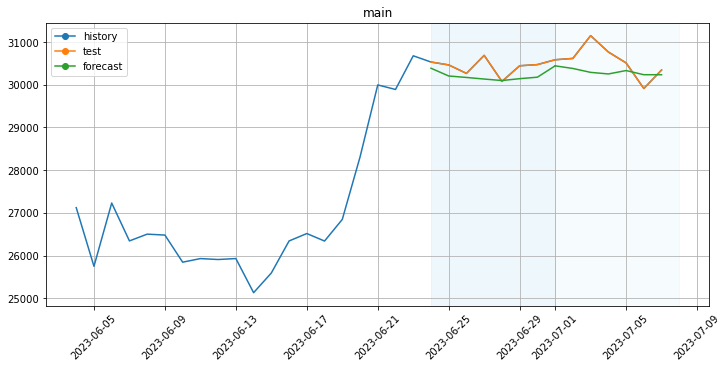

In [24]:
print(f"Best doubled MAE (CV): {best_double_MAE}")
print(f"Best params - LAGS: {BEST_LAGS}",
      f"RNN_LAYERS: {BEST_RNN_LAYERS}",
      f"GRADIENT_CLIP_VAL: {BEST_GRADIENT_CLIP_VAL}",
      f"SHIFT: {BEST_SHIFT}")
plot_backtest(forecast_df=best_forecast, ts=train_ts, history_len=20)

In [23]:
best_pipeline.fit(train_ts)
forecast_ts = best_pipeline.forecast()
forecast_df = forecast_ts.to_pandas()['main'][['target']]
forecast_df = forecast_df.rename(columns={'target':'Price'})
forecast_df['Date'] = forecast_df.index
forecast_df.set_index('Date', inplace=True)
forecast_df.to_csv("pred.csv")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_

Training: 0it [00:00, ?it/s]

/home/kukuyura/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
/home/kukuyura/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:293: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  regressors_index = self.df_exog.loc[:, pd.IndexSlice[segment, self.regre